## PRODUCTION -  Model-agnostic metrics

Date: 30.May.2023

### Purpose

Production-level model-agnostic metrics for all groups

In [18]:
%load_ext autoreload
%autoreload 2

from setup_func import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data from all groups

In [19]:
all_group_df_summary = pd.read_csv(f'{data_dir}/clean_all_group_df_summary.csv', index_col=0)
all_group_longform = pd.read_csv(f'{data_dir}/clean_all_group_longform.csv', index_col=0)
participant_counter = len(all_group_df_summary)

## Load Redcap data

In [20]:
master_demo_df = create_master_demo_df()

Loading master_demo_df...


## Group-specific joined_df

In [21]:
joined_dfs = {
    'alcohol': None,
    'cannabis': None,
}

### Alcohol

In [22]:
tmp_df = master_demo_df[
    (master_demo_df['Group']=='Alcohol')
].copy()

tmp_df = tmp_df[['PID', 'ASSIST_Alcohol']]
joined_dfs['alcohol'] = pd.merge(
    tmp_df,
    all_group_df_summary[
        (all_group_df_summary['Group']=='alcohol')
    ],
    left_on='PID',
    right_on='PID',
    how='inner'
).drop_duplicates(subset='PID')
def assist_filter(arr):
    x = arr.sum()
    if x<=3:
        return 'Low'
    elif x<=26:
        return 'Moderate'
    else:
        return 'Severe'
joined_dfs['alcohol']['ASSIST_Alcohol_Group'] = joined_dfs['alcohol'].filter(regex='ASSIST_Alcohol').apply(assist_filter, axis=1)

### Cannabis

In [23]:
tmp_df = master_demo_df[
    (master_demo_df['Group']=='Cannabis')
].copy()

tmp_df = tmp_df[['PID', 'ASSIST_Cannabis']]
joined_dfs['cannabis'] = pd.merge(
    tmp_df,
    all_group_df_summary[
        (all_group_df_summary['Group']=='cannabis')
    ],
    left_on='PID',
    right_on='PID',
    how='inner'
).drop_duplicates(subset='PID')
def assist_filter(arr):
    x = arr.sum()
    if x<=3:
        return 'Low'
    elif x<=26:
        return 'Moderate'
    else:
        return 'Severe'
joined_dfs['cannabis']['ASSIST_Cannabis_Group'] = joined_dfs['cannabis'].filter(regex='ASSIST_Cannabis').apply(assist_filter, axis=1)

### Subject means and variances

In [24]:
### Calculate mean and std of cravings and mood
for group, joined_df in joined_dfs.items():
    mean_craving_ratings = []
    std_craving_ratings = []
    mean_mood_ratings = [] 
    std_mood_ratings = []
    for pid in joined_df['PID'].unique():
        if pid in all_group_longform['PID'].unique():
            raw_cravings = all_group_longform[
                (all_group_longform['PID']==pid) &
                (all_group_longform['Group']==group)
            ]['Craving Rating'].values
            craving_inds = np.argwhere(raw_cravings!=-1).squeeze()
            craving_inds = craving_inds[(craving_inds!=35)&(craving_inds!=95)]
            craving_ratings = raw_cravings[craving_inds]
            mean_craving_ratings.append(np.mean(craving_ratings))
            std_craving_ratings.append(np.std(craving_ratings))

            raw_mood_ratings = all_group_longform[
                (all_group_longform['PID']==pid) &
                (all_group_longform['Group']==group)
            ]['Mood Rating'].values
            mood_inds = np.argwhere(raw_mood_ratings!=-1).squeeze()
            mood_ratings = raw_mood_ratings[mood_inds]
            mean_mood_ratings.append(np.mean(mood_ratings))
            std_mood_ratings.append(np.std(mood_ratings))
        else:
            print(f'PID {pid} not found in longform data')

    joined_df['mean_craving_ratings'] = mean_craving_ratings
    joined_df['std_craving_ratings'] = std_craving_ratings
    joined_df['mean_mood_ratings'] = mean_mood_ratings
    joined_df['std_mood_ratings'] = std_mood_ratings

## Optimal choice calculation

In [25]:
accuracy_df = pd.melt(
    all_group_df_summary[['Money Accuracy', 'Other Accuracy', 'Group', 'Round']], 
    id_vars=['Group', 'Round'],
    var_name='Block', value_name='p(optimal)'
).replace({
    'Money Accuracy': 'Money', 
    'Other Accuracy': 'Addictive Cue',
    'alcohol': 'Alcohol',
    'cannabis': 'Cannabis',
    'binge': 'Binge',
})
accuracy_df

,Group,Round,Block,p(optimal)
0,Alcohol,1,Money,0.833333
1,Alcohol,1,Money,0.733333
2,Alcohol,1,Money,0.583333
3,Alcohol,1,Money,0.750000
4,Alcohol,1,Money,0.700000
...,...,...,...,...
261,Cannabis,2,Addictive Cue,0.683333
262,Cannabis,2,Addictive Cue,0.766667
263,Cannabis,2,Addictive Cue,0.583333
264,Cannabis,2,Addictive Cue,0.700000


In [26]:
for group in accuracy_df['Group'].unique():
    for block in accuracy_df['Block'].unique():
        subset_df = accuracy_df[
            (accuracy_df['Group']==group) &
            (accuracy_df['Block']==block)
        ]
        print(group, block)
        print(subset_df['p(optimal)'].mean(), subset_df['p(optimal)'].std())
        print(stats.ttest_1samp(subset_df['p(optimal)'], 0.5))

Alcohol Money
0.7100490196078432 0.09174644677880948
TtestResult(statistic=18.879298867857703, pvalue=1.5845406619076192e-28, df=67)
Alcohol Addictive Cue
0.6995098039215686 0.07843676817846783
TtestResult(statistic=20.974856920245035, pvalue=3.7535173620316493e-31, df=67)
Cannabis Money
0.6928205128205128 0.08554204369382484
TtestResult(statistic=18.17315329853759, pvalue=5.84708282191791e-27, df=64)
Cannabis Addictive Cue
0.6958974358974359 0.07894875542341363
TtestResult(statistic=20.005073062463122, pvalue=3.100471993964212e-29, df=64)


In [27]:
# T-test between alcohol and cannabis groups for accuracy
for block in ['Money', 'Addictive Cue']:
    print(block)
    print(stats.ttest_ind(
        accuracy_df[(accuracy_df['Group']=='Alcohol') & (accuracy_df['Block']==block)]['p(optimal)'],
        accuracy_df[(accuracy_df['Group']=='Cannabis') & (accuracy_df['Block']==block)]['p(optimal)'],
    ))

Money
Ttest_indResult(statistic=1.118843303427798, pvalue=0.2652543872092662)
Addictive Cue
Ttest_indResult(statistic=0.26465041181854027, pvalue=0.7916947221540609)


In [28]:
print(stats.ttest_ind(
    accuracy_df[(accuracy_df['Group']=='Alcohol')]['p(optimal)'],
    accuracy_df[(accuracy_df['Group']=='Cannabis')]['p(optimal)'],
))
print(stats.ttest_ind(
    accuracy_df[(accuracy_df['Block']=='Money')]['p(optimal)'],
    accuracy_df[(accuracy_df['Block']=='Addictive Cue')]['p(optimal)'],
))

Ttest_indResult(statistic=1.0155433969217138, pvalue=0.3107766693203309)
Ttest_indResult(statistic=0.378053039937994, pvalue=0.7056949863824205)


In [29]:
accuracy_df_renamed = accuracy_df.copy()
accuracy_df_renamed.columns = ['Group', 'Round', 'Block', 'optimal']

In [30]:
model = smf.ols('optimal ~ C(Group) + C(Block) + C(Group):C(Block)', data=accuracy_df_renamed).fit()
anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Group),0.007217,1.0,1.025783,0.312086
C(Block),0.001004,1.0,0.142634,0.705982
C(Group):C(Block),0.003081,1.0,0.437856,0.508741
Residual,1.843395,262.0,NaN,NaN


Money
Ttest_indResult(statistic=1.118843303427798, pvalue=0.2652543872092662)
Addictive Cue
Ttest_indResult(statistic=0.26465041181854027, pvalue=0.7916947221540609)


Text(0.5, 0, '')

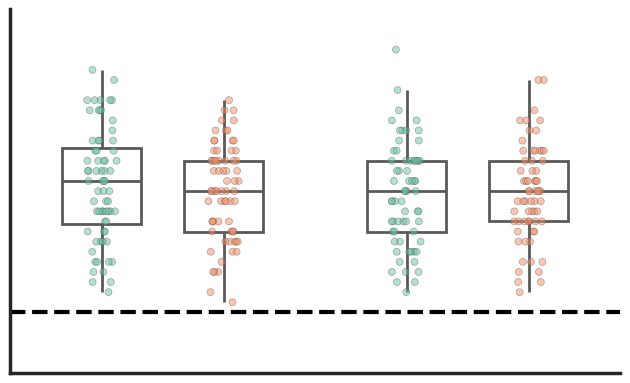

In [31]:
fig, ax = plt.subplots(figsize=(50*mm,30*mm), nrows=1, ncols=1, facecolor='white')

sns.boxplot(
    data=accuracy_df, x='Group', y='p(optimal)', hue='Block', ax=ax,
    palette=[sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]],
    **myboxplotprops
)
sns.stripplot(
    data=accuracy_df, x='Group', y='p(optimal)', hue='Block', ax=ax,
    order=['Alcohol', 'Cannabis'], hue_order=['Money', 'Addictive Cue'],
    palette=[sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]], 
    **mystripplotprops
)
ax.axhline(0.5, linestyle='--', color='black')
ax.set_ylim(0.4, 1.0)
ax.set_ylabel('p(optimal)', labelpad=20)

# plt.legend(fontsize=18)
# ax.legend_.remove()

# calculate t-test between alcohol and cannabis for p(optimal) in Money and Addictive Cue blocks
for block in ['Money', 'Addictive Cue']:
    print(block)
    print(stats.ttest_ind(
        accuracy_df[
            (accuracy_df['Group']=='Alcohol') & (accuracy_df['Block']==block)
        ]['p(optimal)'],
        accuracy_df[
            (accuracy_df['Group']=='Cannabis') & (accuracy_df['Block']==block)
        ]['p(optimal)'],
    ))

sns.despine(offset=0, trim=False)
# remove all labels
plt.xticks([])
plt.yticks([])
plt.ylabel('')
plt.xlabel('')

## Plot choices

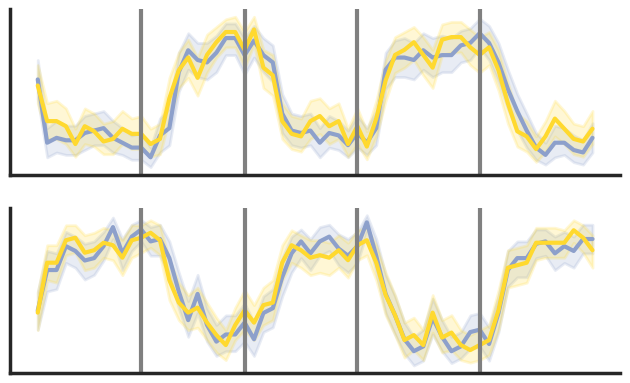

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(50*mm,30*mm), sharex=True)
# Flatten axes
ax = ax.flatten()
for i, block in enumerate(['money', 'other']):
    sns.lineplot(
        data=all_group_longform[
            (all_group_longform['Type']==block) &
            (all_group_longform['Group']=='alcohol')
        ], x='Trial', y='Action', color=sns.color_palette("Set2")[2],
        errorbar=('ci', 95), ax=ax[i], legend=False
    )
    sns.lineplot(
        data=all_group_longform[
            (all_group_longform['Type']==block) &
            (all_group_longform['Group']=='cannabis')
        ], x='Trial', y='Action', color=sns.color_palette("Set2")[5],
        errorbar=('ci', 95), ax=ax[i], legend=False
    )
    ax[i].set_yticks([])
    # ax[i].set_ylabel('Choice', labelpad=10)
    # remove action label
    ax[i].set_ylabel('')
    ax[i].axvline(12, linestyle='-', color='gray')
    ax[i].axvline(23, linestyle='-', color='gray')
    ax[i].axvline(35, linestyle='-', color='gray')
    ax[i].axvline(48, linestyle='-', color='gray')

ax[-1].set_xticks([])
sns.despine(offset=0, trim=False)
plt.xlabel('')
# plt.tight_layout()
plt.figsize=(25*mm,25*mm)

## Model-free metrics

In [35]:
master_dfs = {
    'alcohol': all_group_df_summary.merge(joined_dfs['alcohol'], left_on='PID', right_on='PID', how='inner'),
    'cannabis': all_group_df_summary.merge(joined_dfs['cannabis'], left_on='PID', right_on='PID', how='inner'),
}

### Correlation between severity and model-free performance (score or % optimality)

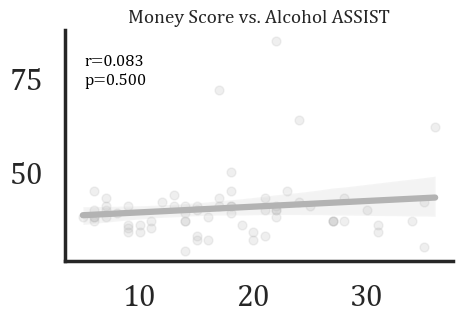

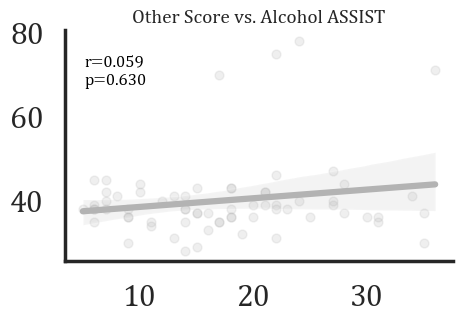

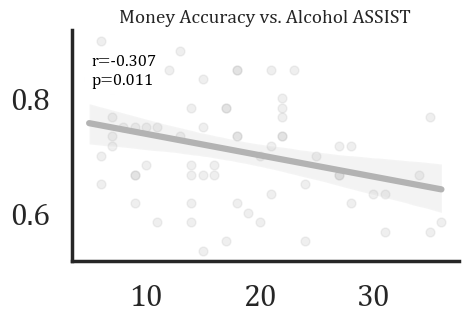

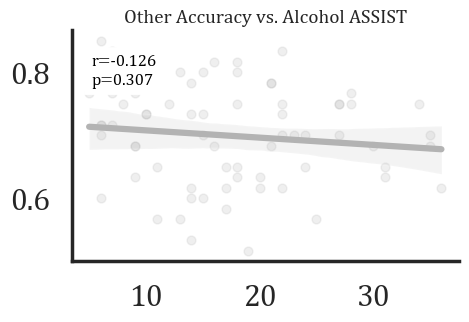

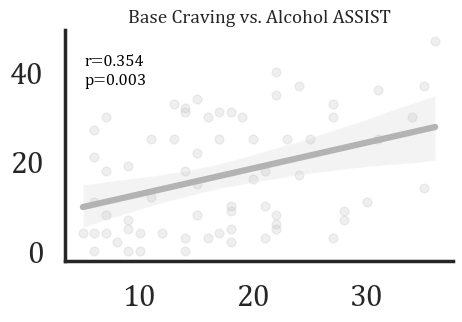

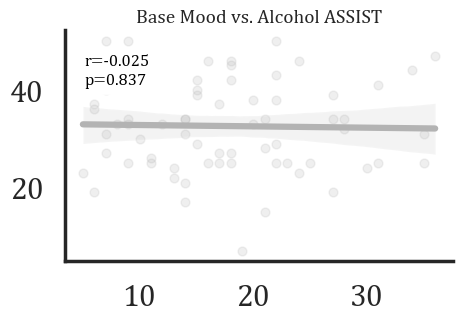

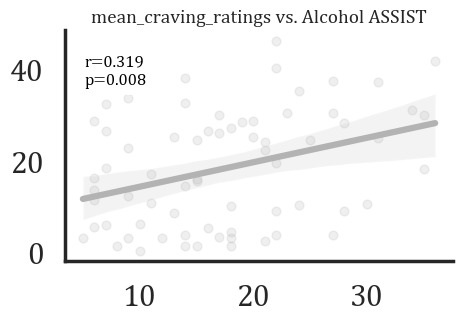

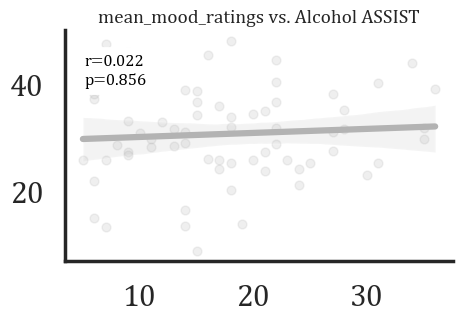

In [36]:
# Alcohol group
severity_score = 'ASSIST_Alcohol'
for y_val in ['Money Score', 'Other Score', 'Money Accuracy', 'Other Accuracy', 'Base Craving', 'Base Mood', 'mean_craving_ratings', 'mean_mood_ratings']:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
    sns.regplot(
        x=severity_score, y=y_val, data=joined_dfs['alcohol'],
        scatter_kws={'alpha': 0.2, 's': 40},
        color=sns.palettes.color_palette('Set2')[7]
    )
    # ax.set_xlabel('Alcohol ASSIST')
    # ax.set_ylabel('Game Score')
    ax.set_title(f'{y_val} vs. Alcohol ASSIST', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')
    sns.despine(offset=0, trim=False)
    r, p = stats.spearmanr(joined_dfs['alcohol'][severity_score], joined_dfs['alcohol'][y_val])
    ax.text(0.05, 0.9, f'r={r:.3f}\np={p:.3f}', transform=ax.transAxes, fontsize=12, ha='left', va='top', color='black', backgroundcolor='white', zorder=1000)

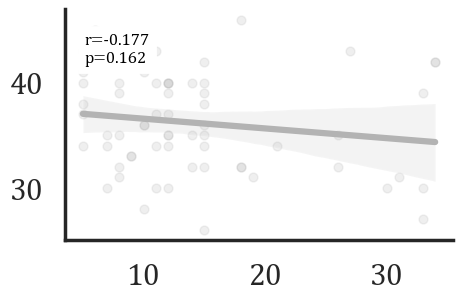

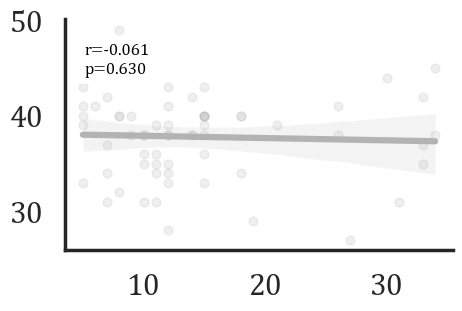

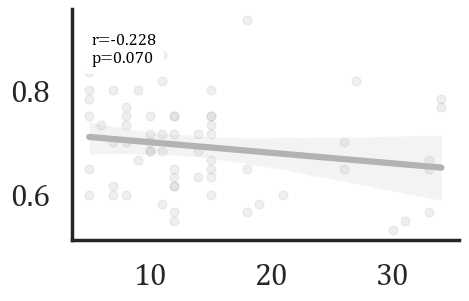

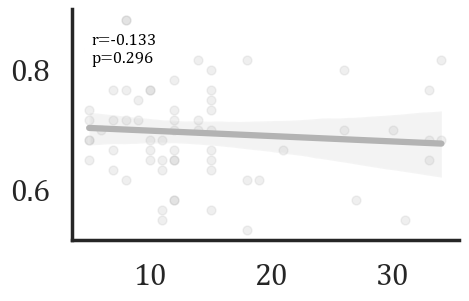

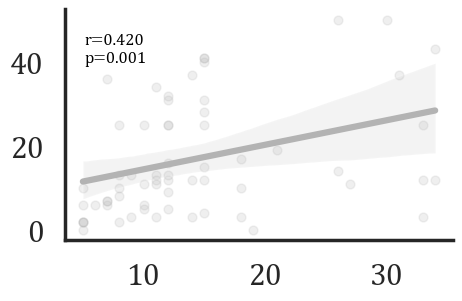

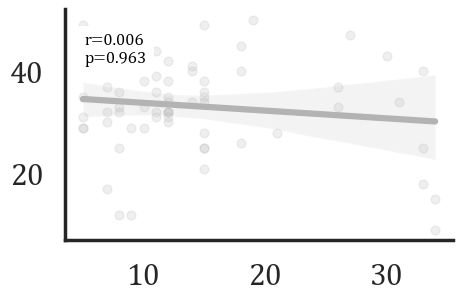

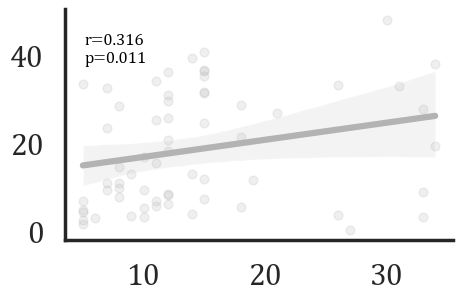

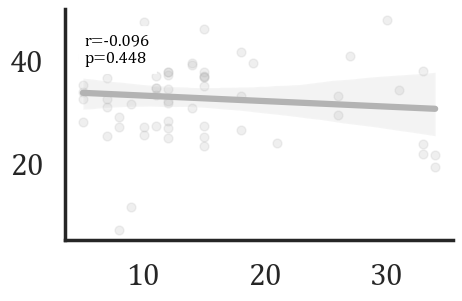

In [37]:
# Cannabis group
severity_score = 'ASSIST_Cannabis'
for y_val in ['Money Score', 'Other Score', 'Money Accuracy', 'Other Accuracy', 'Base Craving', 'Base Mood', 'mean_craving_ratings', 'mean_mood_ratings']:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
    sns.regplot(
        x=severity_score, y=y_val, data=joined_dfs['cannabis'],
        scatter_kws={'alpha': 0.2, 's': 40},
        color=sns.palettes.color_palette('Set2')[7]
    )
    # ax.set_xlabel('Cannabis ASSIST')
    # ax.set_ylabel('Game Score')
    # ax.set_title(f'{y_val} vs. Cannabis ASSIST', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')
    sns.despine(offset=0, trim=False)
    r, p = stats.spearmanr(joined_dfs['cannabis'][severity_score], joined_dfs['cannabis'][y_val])
    ax.text(0.05, 0.9, f'r={r:.3f}\np={p:.3f}', transform=ax.transAxes, fontsize=12, ha='left', va='top', color='black', backgroundcolor='white', zorder=1000)

### Overall distributions of craving and mood ratings

In [38]:
pid_lst = []
group_lst = []
block_lst = []
craving_mean_lst = []
craving_std_lst = []

for group in ['alcohol', 'cannabis']:
    group_subset = all_group_longform[(all_group_longform['Craving Rating']>-1) & (all_group_longform['Group']==group)]
    for pid in group_subset['PID'].unique():
        pid_subset = group_subset[group_subset['PID']==pid]
        for block in ['money', 'other']:
            block_subset = pid_subset[pid_subset['Type']==block]
            pid_lst.append(pid)
            group_lst.append(group)
            block_lst.append(block)
            craving_mean_lst.append(block_subset['Craving Rating'].mean())
            craving_std_lst.append(block_subset['Craving Rating'].std())

craving_df = pd.DataFrame({
    'PID': pid_lst,
    'Group': group_lst,
    'Block': block_lst,
    'Craving Mean': craving_mean_lst,
    'Craving Std': craving_std_lst
})
craving_df

,PID,Group,Block,Craving Mean,Craving Std
0,6111c95332b4f21de44a25c7,alcohol,money,2.60,1.046297
1,6111c95332b4f21de44a25c7,alcohol,other,3.45,1.904980
2,5edf9f945600b52832384409,alcohol,money,11.35,5.815361
3,5edf9f945600b52832384409,alcohol,other,25.45,1.571958
4,60fee74fa3b33a3312af7568,alcohol,money,28.30,1.780006
...,...,...,...,...,...
261,5c44cf2da5487b00011d0b80,cannabis,other,32.25,7.232056
262,5aadbe52811b2000016f7633,cannabis,money,35.45,2.459675
263,5aadbe52811b2000016f7633,cannabis,other,27.70,1.341641
264,60fd60e7587e4f2e860338b4,cannabis,money,26.80,1.321881


In [39]:
# Calculate t-test between money and other blocks for alcohol and cannabis groups across all participants
for group in ['alcohol', 'cannabis']:
    money_cravings = craving_df[craving_df['Group']==group][craving_df['Block']=='money']['Craving Mean']
    other_cravings = craving_df[craving_df['Group']==group][craving_df['Block']=='other']['Craving Mean']
    print(group)
    print(stats.ttest_rel(money_cravings, other_cravings))


alcohol
TtestResult(statistic=-3.140763120391291, pvalue=0.0025078919353545615, df=67)
cannabis
TtestResult(statistic=-2.465574010841236, pvalue=0.016371131815388566, df=64)


In [40]:
# Calculate t-test between money and other blocks for alcohol and cannabis groups across all participants
for group in ['alcohol', 'cannabis']:
    money_cravings = craving_df[craving_df['Group']==group][craving_df['Block']=='money']['Craving Std']
    other_cravings = craving_df[craving_df['Group']==group][craving_df['Block']=='other']['Craving Std']
    print(group)
    print(stats.ttest_rel(money_cravings, other_cravings))


alcohol
TtestResult(statistic=0.7928156380456719, pvalue=0.43068375649788804, df=67)
cannabis
TtestResult(statistic=-0.8412408684300368, pvalue=0.40334528051976526, df=64)


In [41]:
model = smf.ols('Q("Craving Mean") ~ C(Group) + C(Block) + C(Group):C(Block)', data=craving_df).fit()
anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Group),13.080450,1.0,0.076410,0.782441
C(Block),225.750009,1.0,1.318729,0.251868
C(Group):C(Block),2.625966,1.0,0.015340,0.901526
Residual,44851.152682,262.0,NaN,NaN


In [42]:
model = smf.ols('Q("Craving Std") ~ C(Group) + C(Block) + C(Group):C(Block)', data=craving_df).fit()
anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Group),3.413309,1.0,0.308312,0.579191
C(Block),0.001397,1.0,0.000126,0.991046
C(Group):C(Block),5.984348,1.0,0.540545,0.462864
Residual,2900.588381,262.0,NaN,NaN


In [43]:
diff_craving_means = craving_df[craving_df['Block']=='money'].sort_values(by='PID')['Craving Mean'].values - craving_df[craving_df['Block']=='other'].sort_values(by='PID')['Craving Mean'].values
diff_craving_df = pd.DataFrame({
    'PID': craving_df[craving_df['Block']=='money'].sort_values(by='PID')['PID'].values,
    'Group': craving_df[craving_df['Block']=='money'].sort_values(by='PID')['Group'].values,
    'Diff Craving': diff_craving_means
})
diff_craving_df

,PID,Group,Diff Craving
0,55c4fc3dfdf99b559867a416,cannabis,-2.20
1,5608a73fd7def20012b7389d,cannabis,-0.40
2,56849d528f456f000c45e1dd,alcohol,0.10
3,57509d9b363e77000695620b,cannabis,-0.55
4,579181fa913c71000197531b,cannabis,-8.95
...,...,...,...
128,62d72f55501275884cfba46b,cannabis,9.95
129,62db76a315d362749f584469,cannabis,1.80
130,62e02660c3ef175825ab7655,alcohol,0.00
131,62e2f0f23427f0ab91180313,alcohol,-2.95


alcohol
TtestResult(statistic=-3.140763120391291, pvalue=0.0025078919353545615, df=67)
cannabis
TtestResult(statistic=-2.465574010841236, pvalue=0.016371131815388566, df=64)
Group
alcohol     18.286765
cannabis    18.730385
Name: Craving Mean, dtype: float64
Group     Block
alcohol   money    17.268382
          other    19.305147
cannabis  money    17.910769
          other    19.550000
Name: Craving Mean, dtype: float64


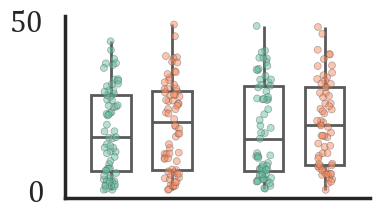

In [46]:
mm = 1/25.4*2
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(50*mm, 30*mm))

sns.stripplot(
    data=craving_df,
    x='Group', y='Craving Mean', hue='Block', hue_order=['money', 'other'], order=['alcohol', 'cannabis'], ax=ax, palette=[sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]],
    **mystripplotprops
)

sns.boxplot(
    data=craving_df,
    x='Group', y='Craving Mean', hue='Block', hue_order=['money', 'other'], order=['alcohol', 'cannabis'], ax=ax, palette=[sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]],
    **myboxplotprops
)
sns.despine(offset=0, trim=False)
# ax.legend_.remove()
ax.set_ylabel('')
ax.set_xlabel('')
# ax.set_yticks([])
# ax.set_xticklabels(['Alcohol', 'Cannabis'])
ax.set_xticks([])
# ax.set_title('Means of Craving Ratings')

# Significance testing within groups
for group in ['alcohol', 'cannabis']:
    print(group)
    print(stats.ttest_rel(
        craving_df[(craving_df['Group']==group) & (craving_df['Block']=='money')]['Craving Mean'],
        craving_df[(craving_df['Group']==group) & (craving_df['Block']=='other')]['Craving Mean']
    ))
# Print mean and std of craving ratings
print(craving_df.groupby(['Group'])['Craving Mean'].mean())
print(craving_df.groupby(['Group', 'Block'])['Craving Mean'].mean())


alcohol
TtestResult(statistic=0.7928156380456719, pvalue=0.43068375649788804, df=67)
TtestResult(statistic=7.024697764324678, pvalue=1.3681797969976515e-09, df=67)
TtestResult(statistic=7.905518257792138, pvalue=3.562478352988815e-11, df=67)
cannabis
TtestResult(statistic=-0.8412408684300368, pvalue=0.40334528051976526, df=64)
TtestResult(statistic=9.12645416715426, pvalue=3.404321890047465e-13, df=64)
TtestResult(statistic=10.20947380073694, pvalue=4.631533419326092e-15, df=64)


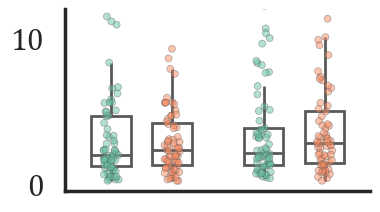

In [47]:
mm = 1/25.4*2
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(50*mm, 30*mm))

sns.stripplot(
    data=craving_df,
    x='Group', y='Craving Std', hue='Block', hue_order=['money', 'other'], order=['alcohol', 'cannabis'], ax=ax, palette=[sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]],
    **mystripplotprops
)

sns.boxplot(
    data=craving_df,
    x='Group', y='Craving Std', hue='Block', hue_order=['money', 'other'], order=['alcohol', 'cannabis'], ax=ax, palette=[sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]],
    **myboxplotprops
)
sns.despine(offset=0, trim=False)
# ax.legend_.remove()
ax.set_ylabel('')
ax.set_xlabel('')
# ax.set_yticks([])
# ax.set_xticklabels(['Alcohol', 'Cannabis'])
ax.set_xticks([])
# ax.set_title('Variance of Craving Ratings')
ax.set_ylim(-0.5, 12)

# Significance testing within groupa
for group in ['alcohol', 'cannabis']:
    print(group)
    print(stats.ttest_rel(
        craving_df[(craving_df['Group']==group) & (craving_df['Block']=='money')]['Craving Std'],
        craving_df[(craving_df['Group']==group) & (craving_df['Block']=='other')]['Craving Std']
    ))
    print(stats.ttest_1samp(
        craving_df[(craving_df['Group']==group) & (craving_df['Block']=='money')]['Craving Std'], 0
    ))
    print(stats.ttest_1samp(
        craving_df[(craving_df['Group']==group) & (craving_df['Block']=='other')]['Craving Std'], 0
    ))

### Correlation between craving and mood

In [30]:
## Within sample craving
group_lst = []
pid_lst = []
block_lst = []
corr_lst = []

for group in ['alcohol', 'cannabis']:
    group_subset = all_group_longform[(all_group_longform['Group']==group)]
    for pid in group_subset['PID'].unique():
        pid_cravings_ = []
        pid_moods_ = []
        for block in ['money', 'other']:
            block_subset = all_group_longform[
                (all_group_longform['Group']==group) &
                (all_group_longform['PID']==pid) &
                (all_group_longform['Type']==block) &
                (all_group_longform['Craving Rating']>-1) &
                (all_group_longform['Mood Rating']>-1)
            ]
            group_lst.append(group)
            pid_lst.append(pid)
            block_lst.append(block)
            corr_lst.append(np.corrcoef(block_subset['Craving Rating'], block_subset['Mood Rating'])[0, 1])
            pid_cravings_ = pid_cravings_ + list(block_subset['Craving Rating'].values)
            pid_moods_ = pid_moods_ + list(block_subset['Mood Rating'].values)
        group_lst.append(group)
        pid_lst.append(pid)
        block_lst.append('combined')
        corr_lst.append(np.corrcoef(pid_cravings_, pid_moods_)[0, 1])

within_pid_corr_df = pd.DataFrame({
    'Group': group_lst,
    'PID': pid_lst,
    'Block': block_lst,
    'Correlation': corr_lst
})
within_pid_corr_df

,Group,PID,Block,Correlation
0,alcohol,6111c95332b4f21de44a25c7,money,-0.429505
1,alcohol,6111c95332b4f21de44a25c7,other,0.434201
2,alcohol,6111c95332b4f21de44a25c7,combined,0.140345
3,alcohol,5edf9f945600b52832384409,money,-0.462419
4,alcohol,5edf9f945600b52832384409,other,-0.345271
...,...,...,...,...
394,cannabis,5aadbe52811b2000016f7633,other,-0.223607
395,cannabis,5aadbe52811b2000016f7633,combined,-0.175906
396,cannabis,60fd60e7587e4f2e860338b4,money,0.329148
397,cannabis,60fd60e7587e4f2e860338b4,other,0.465177


Diff
TtestResult(statistic=-1.0980389565094153, pvalue=0.2761179209881474, df=67)
alcohol money
TtestResult(statistic=-1.0334214242614577, pvalue=0.3051225811941456, df=67)
-0.06278549398475954
alcohol other
TtestResult(statistic=0.3830156999735194, pvalue=0.7029206445023055, df=67)
0.02111231872351887
Diff
TtestResult(statistic=-0.9724566188808076, pvalue=0.3344845878212347, df=64)
cannabis money
TtestResult(statistic=-0.039540252525171564, pvalue=0.968582748680106, df=64)
-0.0022270886514741996
cannabis other
TtestResult(statistic=1.0273200423705886, pvalue=0.30813694367830036, df=64)
0.06488249470102063


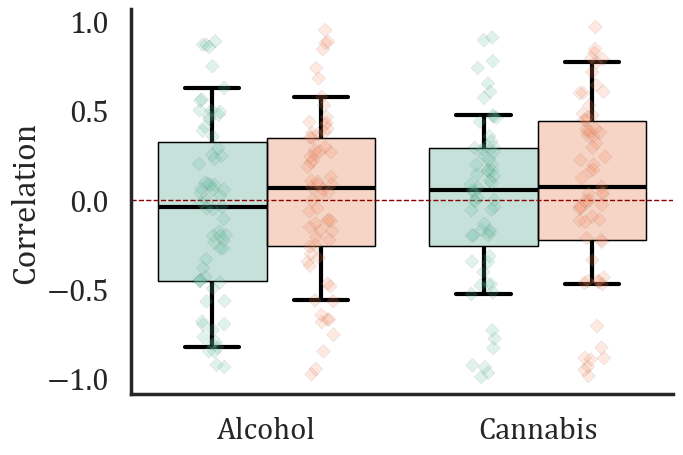

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
sns.stripplot(
    data=within_pid_corr_df,
    x='Group', y='Correlation', hue='Block', hue_order=['money', 'other'], order=['alcohol', 'cannabis'],
    dodge=True, marker='D', size=7,
    edgecolor='black', linewidth=0.2,
    alpha=0.2, palette='Set2'
)

sns.boxplot(
    data=within_pid_corr_df,
    x='Group', y='Correlation', hue='Block', 
    hue_order=['money', 'other'], order=['alcohol', 'cannabis'],
    dodge=True, palette='Set2', ax=ax,
    boxprops=dict(alpha=0.4), notch=False,
    showfliers=False, whis=0.5,
)

sns.boxplot(
    data=within_pid_corr_df,
    x='Group', y='Correlation', hue='Block', 
    hue_order=['money', 'other'], order=['alcohol', 'cannabis'],
    dodge=True, palette='Set2', ax=ax,
    boxprops=dict(fill=None, edgecolor='black'), notch=False,
    showfliers=False, whis=0.5,
    whiskerprops=dict(linewidth=3, color='black'),
    capprops=dict(linewidth=3, color='black'),
    medianprops=dict(linewidth=3, color='black')
)

# Add a line at 0
ax.axhline(0, color='darkred', linestyle='--', linewidth=1)

ax.set_xticklabels(['Alcohol', 'Cannabis'])
ax.set_xlabel('')
ax.legend_.remove()
sns.despine(offset=0, trim=False)

# Significance testing within groups
for group in ['alcohol', 'cannabis']:
    group_corrs = within_pid_corr_df[(within_pid_corr_df['Group']==group)]['Correlation'].replace(np.nan, 0)
    print('Diff')
    print(stats.ttest_rel(
        group_corrs[(within_pid_corr_df['Block']=='money')],
        group_corrs[(within_pid_corr_df['Block']=='other')]
    ))
    for block in ['money', 'other']:
        print(group, block)
        groupblock_corrs = within_pid_corr_df[
            (within_pid_corr_df['Group']==group) &
            (within_pid_corr_df['Block']==block)
        ]['Correlation'].replace(np.nan, 0)
        print(stats.ttest_1samp(groupblock_corrs, 0))
        print(groupblock_corrs.mean())